In [3]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /cats_and_dogs_filtered.zip

--2020-03-07 16:13:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/cats_and_dogs_filtered.zip’

/cats_and_dogs_filt 100%[===================>]  65.43M   259MB/s    in 0.3s    

2020-03-07 16:13:44 (259 MB/s) - ‘/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

In [0]:
base_dir = '/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-03-07 16:13:51--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   241MB/s    in 0.3s    

2020-03-07 16:13:51 (241 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
last_layer = pre_trained_model.get_layer('mixed10')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x) 
x = layers.Dense  (1, activation='sigmoid')(x) 
model = Model( pre_trained_model.input, x)  

In [0]:
model.summary()

In [11]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_datagen  = ImageDataGenerator( rescale = 1.0/255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150,150))

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.80):
      print("\nReached 80% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()
history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2,
                              callbacks=[callbacks])

Epoch 1/15
Epoch 1/15
100/100 - 193s - loss: 0.4708 - acc: 0.7920 - val_loss: 0.6459 - val_acc: 0.9090
Epoch 2/15
Epoch 1/15
100/100 - 191s - loss: 0.4318 - acc: 0.8080 - val_loss: 0.7608 - val_acc: 0.9020
Epoch 3/15
Epoch 1/15
100/100 - 191s - loss: 0.4234 - acc: 0.8235 - val_loss: 1.5270 - val_acc: 0.8540
Epoch 4/15
Epoch 1/15
100/100 - 191s - loss: 0.4138 - acc: 0.8180 - val_loss: 1.1471 - val_acc: 0.8850
Epoch 5/15
Epoch 1/15
100/100 - 191s - loss: 0.4295 - acc: 0.8170 - val_loss: 0.8592 - val_acc: 0.9080
Epoch 6/15
Epoch 1/15
100/100 - 191s - loss: 0.4033 - acc: 0.8315 - val_loss: 1.0321 - val_acc: 0.8970
Epoch 7/15
Epoch 1/15
100/100 - 190s - loss: 0.4146 - acc: 0.8340 - val_loss: 0.7426 - val_acc: 0.9200
Epoch 8/15
Epoch 1/15
100/100 - 191s - loss: 0.4197 - acc: 0.8265 - val_loss: 0.9560 - val_acc: 0.8730
Epoch 9/15
Epoch 1/15
100/100 - 191s - loss: 0.4171 - acc: 0.8175 - val_loss: 0.7569 - val_acc: 0.9100
Epoch 10/15
Epoch 1/15
100/100 - 191s - loss: 0.4238 - acc: 0.8155 - val_

Text(0.5, 1.0, 'Training and validation loss')

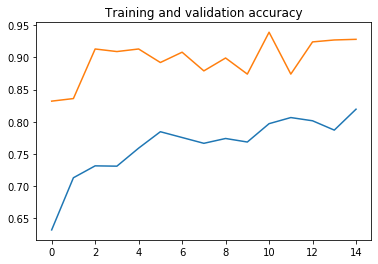

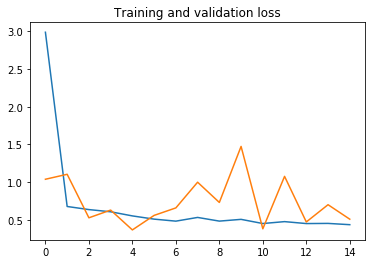

In [14]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc))

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )